## Imports/ Random and quaternion functions

In [3]:
import pickle
import sys
import time 
import numpy as np
import matplotlib.pyplot as plt
from jax import jit
import jax.numpy as jnp
from jax import grad
import transforms3d as t3d

def tic():
  return time.time()

def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

@jit
def pq(p, q):
    ''' batch version of pq'''
    if q.ndim == 1:
      q = q[None, :] 
    if p.ndim == 1:
      p = p[None, :] 

    ps, pv = p[:, 0], p[:, 1:]
    qs, qv = q[:, 0], q[:, 1:]
    b = ps[:, None]*qv + qs[:, None]*pv + jnp.cross(pv, qv, axisa=1, axisb=1)
    result = jnp.column_stack([ps*qs - jnp.sum(pv * qv, axis=1), b[:, 0], b[:, 1], b[:, 2]])
    if result.shape[0] == 1:
        return result[0] 
    return result

def expq(qb):
    ''' batch version of expq'''
    v1 = []
    if qb.ndim == 1:
       d=1
       b = qb[None, :]
    else:
        d = qb.shape[0]
        b = qb

    for i in range(d):
        q = b[i]
        s, v = q[0], q[1:]
        v_norm = jnp.linalg.norm(v)
        qv_sin = jnp.sin(v_norm)
        qv_cos = jnp.cos(v_norm)
        v1.append(jnp.exp(s)*jnp.array([qv_cos, qv_sin*v[0]/v_norm, qv_sin*v[1]/v_norm, qv_sin*v[2]/v_norm]))
    return jnp.array(v1)

@jit
def logq(q):
    ''' batch version of logq'''
    if q.ndim == 1:
      q = q[None, :] 
    s, v = q[:, 0], q[:, 1:]
    qv_norm = jnp.linalg.norm(v, axis=1)+ 1e-6
    norm = jnp.linalg.norm(q, axis=1) + 1e-6
    b = (v / qv_norm[:,None]) * jnp.arccos(s / norm)[: , None]
    result = jnp.column_stack([jnp.log(norm), b])
    return result

@jit
def qinv(q):
    ''' batch version of qinv'''
    if q.ndim == 1:
      q = q[None, :] 
    norm_sq = jnp.linalg.norm(q, axis=1)**2
    result = jnp.column_stack([q[:, 0], -q[:, 1], -q[:, 2], -q[:, 3]]) / norm_sq[:, None]
    return result

## Class definitions

In [4]:
class camData:
    def __init__(self, dataset='1'):
        ts = tic()
        cfile = "../data/cam/cam" + dataset + ".p"
        cam = read_data(cfile)
        self.ts = cam['ts'].astype(float)
        self.camd = cam['cam']
        toc(ts, "Loading cam data")

    def visualizeTest(self,start = 0):
        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
        if start + 250 > self.camd.shape[3]:
            print("Start index out of range")
            return
        for i in range(5):
            axs[i].imshow(self.camd[:,:,:,start+i*50])
            axs[i].axis('off')
            axs[i].set_title('ts: ' + str(self.ts[0,i*10]) + 's')

        plt.show()

In [5]:
class viconData:

    def __init__(self, dataset):
        self.ts, self.vicd = self.__load_data(dataset)
        self.__euler_angles = None

    def euler_angles(self,plot=False):
        if self.__euler_angles is None:
            self.__euler_angles = self.__compute_euler_angles()
        if plot:
            plt.plot(self.ts[0],self.__euler_angles[:,0])
            plt.plot(self.ts[0],self.__euler_angles[:,1])
            plt.plot(self.ts[0],self.__euler_angles[:,2])
            plt.legend(['Wz','Wy','Wx'])
            plt.title('IMU Euler Angles')
            plt.show()
        return self.__euler_angles
    
    def __compute_euler_angles(self):
        vicd_euler = []
        for i in range(self.vicd.shape[2]):
            
            vicd_euler.append(t3d.euler.mat2euler(self.vicd[:,:,i], axes='sxyz'))
            
        return jnp.array(vicd_euler)

    def __load_data(self, dataset):
        tms = tic()
        vfile = "../data/vicon/viconRot" + dataset + ".p"
        viconD = read_data(vfile)
        ts = viconD['ts']
        vicd = viconD['rots']
        toc(tms,"Vicon data import")
        return ts, vicd
    
    def Display_Euler_angles(self):
        fig, axs = plt.subplots(1, 3, figsize=(15, 3))
        l = ['x', 'y', 'z']
        for i in range(3):
            axs[i].plot(self.ts[0], self.euler_angles()[:,i])
            axs[i].set_title('Euler angle ' + l[i])
            axs[i].set_xlabel('Time (s)')
            axs[i].set_ylabel('Angle (rad)')

        plt.show()

In [6]:
class imuData:
    
    def __init__(self, dataset,scaler_acc =0,scaler_gyro = 0,bias_vals = [0,0,0,0,0,0]):
        self.__dataset = dataset
        self.ts, self.vals_raw = self.__load_Data(dataset)
        self.bias_vals = bias_vals
        self.vals_p = self.__process_imu(scaler_acc,scaler_gyro)
        self.__quaternions = None
        self.__euler_angles = None
        self.__dts = self.__delta_ts()
        self.__euler_constant = self.__calc_euler_constant()
        self.__at_estimate = None
        self.__rotations = None
    
    
    def rotations(self):
        ''' Holder for rotations to avoid recomputation'''
        if self.__rotations is None:
            self.__rotations = self.estimate_rotations()
        return self.__rotations

    def quaternions(self):
        ''' Holder for quaternions to avoid recomputation'''
        if self.__quaternions is None:
            self.__quaternions = self.estimate_quat()
        return self.__quaternions
    
    def at_estimate(self,plot = False):
        ''' Holder for at estimate to avoid recomputation'''
        if self.__at_estimate is None:
            self.__at_estimate = self.h(plot = plot)
        return self.__at_estimate

    def euler_angles(self,plot = False):
        ''' Holder for euler angles to avoid recomputation'''
        if self.__euler_angles is None:
            self.__euler_angles = self.estimate_euler()
        if plot:
            plt.plot(self.ts[0],self.__euler_angles[:,0][:-1])
            plt.plot(self.ts[0],self.__euler_angles[:,1][:-1])
            plt.plot(self.ts[0],self.__euler_angles[:,2][:-1])
            plt.legend(['Wz','Wy','Wx'])
            plt.title('IMU Euler Angles')
            plt.show()
        return self.__euler_angles

    def __load_Data(self, dataset):
        ''' load imu data from pickle file'''
        tms = tic()
        ifile = "../data/imu/imuRaw" + dataset + ".p"
        imud = read_data(ifile)
        ts = imud['ts'].astype(float)
        vals = imud['vals'].astype(float)
        toc(tms,"IMU data import")
        return ts, vals
        
    def __process_imu(self,scaler_acc,scaler_gyro):
        tms = tic()
        if scaler_acc == 0:
            scaler_acc = 3300/1023/300
        if scaler_gyro == 0:
            scaler_gyro = 3300/1023*jnp.pi/180/3.33
        if self.bias_vals == [0,0,0,0,0,0]:
            a = jnp.mean(self.vals_raw[:,:100],axis=1)
            b = jnp.mean(self.vals_raw[:,-100:],axis=1)
            self.bias_vals = (a+b)/2

        
        def f(x, bias,graph):
            if graph <3:
                scaler = scaler_acc
                if graph <2:
                    scaler = -scaler_acc
                return (x-bias)*scaler
            
            return (x-bias)*scaler_gyro
        
        vls_p = np.zeros(self.vals_raw.shape)
        for i in range(6):
            vls_p[i] = f(self.vals_raw[i],self.bias_vals[i],i)
        toc(tms,"Process IMU")
        return vls_p

    def __delta_ts(self):
        d = [self.ts[0,1]-self.ts[0,0]]
        d.extend([(self.ts[0,i]-self.ts[0,i-1])/2 for i in range(1,self.ts.shape[1])])
        return jnp.array(d)

    def __calc_euler_constant(self):
        a = self.__dts*jnp.array([jnp.zeros(self.vals_p[4,:].shape),self.vals_p[4,:],self.vals_p[5,:],self.vals_p[3,:]])
        return expq(a.T)

    def estimate_quat(self,qt = None):
        ''' Estimate quaternion from IMU data using zyx euler angles'''
        tmr = tic()
        if qt is None:
            q = [jnp.array([1,0,0,0])]
        
            for i in range(self.vals_p.shape[1]):
                q_temp = pq(q[i],self.__euler_constant[i])
                q.append(q_temp/jnp.linalg.norm(q_temp))
            toc(tmr,"Estimated Quaternions")
            return jnp.array(q)
        else:
            q_temp = pq(qt,self.__euler_constant)
            return q_temp /(jnp.linalg.norm(q_temp))
            
    def estimate_euler(self,q=None):
        ''' Estimate euler angles from IMU data using zyx euler angles'''
        tmr = tic()
        if q is None:
            q = self.quaternions()
 
        euler = []
        for i in range(len(q)):
            euler.append(t3d.euler.quat2euler(q[i]))
        toc(tmr,"Estimated Euler Angles")
        return jnp.array(euler)

    def h(self,q=None,v = None, plot=False, file = False):
            ''' Estimates [0,ax,ay,az] from quaternion and [w,wx,wy,wz] vectorized'''
            if q is None:
                q = self.quaternions()

            if v is None:
                v = jnp.array([0,0,0,1])

            b = pq(qinv(q),pq(v,q))
            if b.ndim == 1:
                b = b[None, :] 
            at = jnp.array([b[:,0],b[:,1],b[:,2],b[:,3]-1])

            if plot:
                fig, axs = plt.subplots(3, 1, figsize=(7, 6))
                fig.suptitle('(Dataset: '+str(self.__dataset) +')\n Estimated Acceleration', fontsize=16)
                axs[0].plot(self.ts[0], at[1][:-1])
                axs[0].plot(self.ts[0], self.vals_p[0])
                axs[0].set_title("Ax")
                axs[0].legend(['Estimated','IMU'])

                axs[1].plot(self.ts[0], at[2][:-1])
                axs[1].plot(self.ts[0], self.vals_p[1])
                axs[1].set_title("Ay")
                axs[1].legend(['Estimated','IMU'])

                axs[2].plot(self.ts[0], at[3][:-1])
                axs[2].plot(self.ts[0], self.vals_p[2])
                axs[2].set_title("Az")
                axs[2].legend(['Estimated','IMU'])

                plt.tight_layout()
                if file: fig.savefig('./imagesA/D'+str(self.__dataset)+'-EST-Ac.png')
                else: plt.show()
            return at
            
    def plot_imu(self,raw = False,file = False):
        tms = tic()
        ts = self.ts
        if raw:
            vals = self.vals_raw
            title = "Raw IMU"
        else:
            vals = self.vals_p
            title = "Processed IMU"
            
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Dataset: '+str(self.__dataset)+' '+title, fontsize=16)
        l = ['Ax', 'Ay', 'Az', 'Wz', 'Wx', 'Wy']
        for i in range(2):
            for j in range(3):
                axs[i, j].plot(ts[0], vals[i*3+j])
                axs[i, j].set_title('IMU ' + str(l[i*3+j]))
                axs[i, j].set_xlabel('time (s)')
                axs[i, j].set_ylabel('vals')

        plt.tight_layout()
        
        if file and raw: fig.savefig('./imagesA/D'+str(self.__dataset)+'-PRO-R.png')
        elif file: fig.savefig('./imagesA/D'+str(self.__dataset)+'-PRO-P.png')
        else: plt.show()

        toc(tms,"Plot IMU")
        

In [7]:
class quaternion_Optimization:

    def __init__(self, dataset='1', max_iter=100, learning_rate=0.1, tol=1e-6, Vicon=True):
        self.__dataset = dataset
        self.imu = imuData(dataset)
        if Vicon:
            self.vicd = viconData(str(dataset))
            self.vicd_euler = self.vicd.euler_angles()
        else:
            self.vicd = None
            self.vicd_euler = None
        self.imu_euler = self.imu.euler_angles()
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.__euler_optimized = None
        self._op_acc = None
        self.__rotations = None
        self.__op_quat = None

    def rotations(self):
        ''' Holder for rotations to avoid recomputation'''
        if self.__rotations is None:
            self.__rotations = self.estimate_rotations()
        return self.__rotations

    # Results for each step of the optimization
    def calibration_results(self,file=False):
        self.imu.plot_imu(raw=True,file=file)
        self.imu.plot_imu(file=file)

    def estimated_nextq_results(self,file = False):
        fig, axs = plt.subplots(3, 1, figsize=(7, 6))
        fig.suptitle('(Dataset: '+str(self.__dataset)+')\n Vicon vs Q+1 IMU Euler Angles', fontsize=16)

        axs[0].plot(self.vicd.ts[0], self.vicd_euler[:, 0])
        axs[0].plot(self.imu.ts[0], self.imu_euler[:, 0][:-1])
        axs[0].legend(['Vicon', 'IMU'])
        axs[0].set_title("Wz")

        axs[1].plot(self.vicd.ts[0], self.vicd_euler[:, 1])
        axs[1].plot(self.imu.ts[0], self.imu_euler[:, 1][:-1])
        axs[1].legend(['Vicon', 'IMU'])
        axs[1].set_title("Wy")

        axs[2].plot(self.vicd.ts[0], self.vicd_euler[:, 2])
        axs[2].plot(self.imu.ts[0], self.imu_euler[:, 2][:-1])
        axs[2].legend(['Vicon', 'IMU'])
        axs[2].set_title("Wx")

        plt.tight_layout()
        if file: fig.savefig('./imagesA/D'+str(self.__dataset)+'-EST-Q.png')
        else: plt.show()
        
    def estimate_at_results(self,file = False):
        self.imu.h(plot=True,file= file)
        
    def pre_optimization_results(self,file=False):
        fig, axs = plt.subplots(2, 3, figsize=(8, 6))
        fig.suptitle(' Pre optimization Dataset: '+str(self.__dataset)+' \n Actual vs Estimated', fontsize=16)
        l = ['Ax', 'Ay', 'Az', 'Wz', 'Wx', 'Wy']
        for i in range(2):
            for j in range(3):
                if i ==0:
                    axs[i, j].plot(self.imu.ts[0], self.imu.vals_p[i*3+j])
                    axs[i, j].plot(self.imu.ts[0], self.imu.at_estimate()[i*3+j+1][:-1])
                    axs[i, j].set_title(str(l[i*3+j])+' IMU and (at) Estimation ' )
                    axs[i, j].legend(['IMU', 'Estimation'])
                    axs[i, j].set_xlabel('time (s)')
                    axs[i, j].set_ylabel('vals')
                else:
                    axs[i, j].plot(self.vicd.ts[0], self.vicd_euler[:, j])
                    axs[i, j].plot(self.imu.ts[0], self.imu_euler[:, j][:-1])
                    axs[i, j].set_title(str(l[i*3+j])+ ' Vicon and q+1 Estimation' )
                    axs[i, j].legend(['Vicon', 'Estimation'])
                    axs[i, j].set_xlabel('time (s)')
                    axs[i, j].set_ylabel('vals')           

        plt.tight_layout()
        if file: fig.savefig('./imagesA/D'+str(self.__dataset)+'-PreOp-F.png')
        else: plt.show()

    def final_results(self,full=False,angleData=True,accelData=False,file = False):

        if angleData:
            fig, axs = plt.subplots(3, 1, figsize=(7, 6))
            fig.suptitle('(Dataset: '+str(self.__dataset) +')\n Optimized Estimate', fontsize=16)
            titles = ["Wx", "Wy", "Wz"]

            for i in range(3):
                
                axs[i].plot(self.vicd.ts[0], self.vicd_euler[:, i])
                axs[i].plot(self.imu.ts[0], self.optimized_euler()[:, i][:-1])
                axs[i].legend(['Vicon','Optimized'])
                axs[i].set_title(titles[i])

            plt.tight_layout()
           
            if file: fig.savefig('./imagesA/D'+str(self.__dataset)+'-FOR-An.png')
            else: plt.show()

        if accelData:
            fig, axs = plt.subplots(3, 1, figsize=(7, 6))
            fig.suptitle('(Dataset: '+str(self.__dataset) +')\n Optimized Estimate', fontsize=16)
            titles = ["ax", "ay", "az"]

            for i in range(3):
                axs[i].plot(self.imu.ts[0], self.imu.vals_p[i])
                axs[i].plot(self.imu.ts[0], self.optimize_acc()[i+1][:-1])
                axs[i].legend(['IMU','Optimized'])
                axs[i].set_title(titles[i])

            plt.tight_layout()
            
            if file: fig.savefig('./imagesA/D'+str(self.__dataset)+'-FOR-Ac.png')
            else: plt.show()

        if full:
            fig, axs = plt.subplots(2, 3, figsize=(9, 7))
            fig.suptitle('(Dataset: '+str(self.__dataset) +')\n Optimized Estimate of Acceleration', fontsize=16)
            l = ['Ax', 'Ay', 'Az', 'Wx', 'Wy', 'Wz']
            for i in range(2):
                for j in range(3):
                    if i ==0:
                        axs[i, j].plot(self.imu.ts[0], self.imu.vals_p[i*3+j])
                        axs[i, j].plot(self.imu.ts[0], self.optimize_acc()[i*3+j+1][:-1])
                        axs[i, j].set_title(str(l[i*3+j])+' IMU and opt. (at) Estimation ' )
                        axs[i, j].legend(['IMU', 'Estimation'])
                        axs[i, j].set_xlabel('time (s)')
                        axs[i, j].set_ylabel('vals')
                    else:
                        axs[i, j].plot(self.vicd.ts[0], self.vicd_euler[:, j])
                        axs[i, j].plot(self.imu.ts[0], self.optimized_euler()[:, j][:-1])
                        axs[i, j].set_title(str(l[i*3+j])+ ' Vicon and opt. q Estimation' )
                        axs[i, j].legend(['Vicon', 'Estimation'])
                        axs[i, j].set_xlabel('time (s)')
                        axs[i, j].set_ylabel('vals')           

            plt.tight_layout()
            
            if file: fig.savefig('./imagesA/D'+str(self.__dataset)+'-FOR-F.png')
            else: plt.show()

    # Active functions
    def optimized_euler(self):
        if self.__euler_optimized is None:
            self.train()
        return self.__euler_optimized
    
    def optimize_quat(self):
        if self.__op_quat is None:
            self.train()
        return self.__op_quat
    
    def optimize_acc(self):
        if self.__op_acc is None:
            self.train()
        return self.__op_acc

    def train(self,lossData = False):
        tm = tic()
        self.__op_quat = self.__grad_decent(self.imu.quaternions(),self.learning_rate,self.max_iter,self.tol,lossData)
        self.__euler_optimized = self.imu.estimate_euler(self.__op_quat)
        self.__op_acc = self.imu.h(self.__op_quat)
        toc(tm,"Training")
        if lossData:
            print("Final Cost: ",self.c(self.__op_quat))
        
    def c(self,q):
        cq = 0.5*jnp.linalg.norm(2*logq(pq(qinv(q[1:]),self.imu.estimate_quat(q[:-1]))))**2 + 0.5*jnp.linalg.norm(jnp.array([self.imu.vals_p[:3]-self.imu.h(q)[1:,:-1]]))**2 
        return cq
    
    def __grad_decent(self,q,learning_rate,max_iter,tol,lossData):
        loss = [self.c(q)]
        q0 = q.copy()
        alpha = learning_rate
        for i in range(max_iter):
            qn = q0 - alpha*grad(self.c)(q0)
            qn = qn/jnp.linalg.norm(qn)
            n = self.c(qn)
            
            if i % 5 == 0 and lossData:
                print('step: ',i,'cost: ',n,'alpha: ',alpha)
            
            if loss[-1] - n < 0 and i !=0:
                alpha = alpha/2
                if alpha < 1e-6:
                    break
            else:
                loss.append(n)
                q0 = qn
            
            if abs(loss[-2]-n)<tol and  i> 15:
                if lossData:
                    print("loss: ",loss[-1], "Step: ",i, "Alpha: ",alpha)
                break

        if lossData:
            plt.plot(loss)
            plt.show()  
        
        return q0
    
    def estimate_rotations(self):
        '''return the estimated rotations based on optimized euler angles'''
        def R(q):
            return t3d.quaternions.quat2mat(q).T
        Rot = []
        for i in range(self.optimize_quat().shape[0]):
            Rot.append(R(self.optimize_quat()[i]))
        self.__rotations = jnp.array(Rot)
        return self.__rotations
            



### Full results for part A

In [ ]:
i = 9
total_time = tic()
dataset = str(i)
test = quaternion_Optimization(dataset,Vicon=True,)
test.calibration_results(file=True)
test.train(lossData=True)
test.estimated_nextq_results(file=True)
test.estimate_at_results(file=True)
test.pre_optimization_results(file=True)    
test.final_results(full=True,accelData=True,file=True)
toc(total_time,str(i))

# Part B 
pannorama stitching 


In [8]:
def spherical_to_cartesianb(theta, phi):
    # convert spherical coordinates to cartesian
    x = np.cos(phi) * np.cos(theta)
    y = np.cos(phi) * np.sin(theta)
    z = np.sin(phi)
    return np.stack([x, y, z], axis=-1)

def cartesian_to_sphericalb(cart_cords):
    x, y, z =cart_cords[:,:,0], cart_cords[:,:,1], cart_cords[:,:,2]
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arcsin(z / r)
    theta = np.arctan2(y, -x)
    return theta, phi 

def project_to_panob(theta,phi, shape):
    h, w, _ = shape
    coln = ((w - 1)/(2*np.pi))* (theta) 
    rown = (h - 1) * (phi+ np.pi/2) / np.pi
    return rown, coln

def get_Rotations(rot,cam,ts):
    a = []
    j =0
    for i in range(1,cam.camd.shape[3]):
        while ts[0,j] <= cam.ts[0,i] and j < ts.shape[1]-1:
            j += 1
        a.append(rot[:,:,j-1])
    return np.array(a)


In [9]:
def run(dataset='1', Vicon = True):
    cam = camData(dataset)
    ts = None
    if Vicon:
        vicon = viconData(dataset)
        ts = vicon.ts
        rot = vicon.vicd
    else:
        q = quaternion_Optimization(dataset, Vicon = False)
        ts = q.imu.ts
        rot = q.rotations().transpose(2,1,0)
       

    height, width, d,_ = cam.camd.shape
    PanoImage = np.zeros((int(2*height),int(3*width),d),dtype = int)

    phi_vals = -np.pi/8 + (np.pi/4) * np.arange(height) / (height-1)
    theta_vals = -np.pi/6 + (np.pi/3) * np.arange(width) / (width-1)

    phi_grid, theta_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')

    cartesian_coords = spherical_to_cartesianb(theta_grid, phi_grid)

    rotation_matrixs = get_Rotations(rot,cam,ts)
    
    for i,r in enumerate(rotation_matrixs):
        rotated_coords = cartesian_coords@r.T + np.array([0,0,0.1])

        theta, phi = cartesian_to_sphericalb(rotated_coords)
        
        row_ind, col_ind = project_to_panob(theta, phi ,PanoImage.shape)
        
        for row in range(height):
            for col in range(width):
                PanoImage[int(row_ind[row,col]) ,int(col_ind[row,col]),:]= cam.camd[row,col,:,i].astype(int)
    
    plt.imshow(PanoImage)
    plt.show() 

    # if Vicon:
    #     plt.imsave('./imagesB/'+dataset+'Vf.png', PanoImage.astype(np.uint8))
    # else:
    #     plt.imsave('./imagesB/'+dataset+'If.png', PanoImage.astype(np.uint8))

Loading cam data took: 5.795631170272827 sec.

Vicon data import took: 0.008323192596435547 sec.



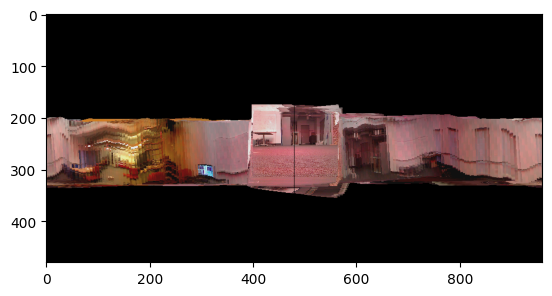

In [11]:
run('8')